## Summary of notebook:

This notebook details the code used to build the MPRI model. After successfully building the model, a Proof of Concept using the MPRI model was then developed using the open-source dataset augmented with Gaussian noise (with filename 'augmented_features_10_ue1_v2_ds.npy' and 'augmented_labels_10_ue1_v2_ds.npy').

Below shows the main sections of this notebook.
1. Development of MPRI model
2. Proof of Concept for MPRI model

The following past works were referenced.

1. K. Gao, H. Wang, H. Lv and W. Liu, "Toward 5G NR High-Precision Indoor Positioning via Channel Frequency Response: A New Paradigm and Dataset Generation Method," in IEEE Journal on Selected Areas in Communications, vol. 40, no. 7, pp. 2233-2247, July 2022, doi: 10.1109/JSAC.2022.3157397.

In [94]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## Development of MPRI model

In [95]:
# Whole network composed of 63 layers, approximately 2.6m total no. of parameters
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D,\
                                    GlobalAvgPool2D, Dense, Add, concatenate, Input,\
                                    Dropout
from tensorflow.keras import Model

# Note: tf version 2.9.1 does not have Identity layer. Implement our own identity layer which is argument insensitive
# and returns its inputs argument as output

In [96]:
def input_module(x):
    
    print('Beginning of input module')
    
    # Set no. of filters to 256 to match the output of Add layer at the end of
    # upper half of MPRI module
    x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Normally, strides = 2 to reduce dimensions but set strides =1 for now to match
    # output shapes
    x = MaxPool2D(pool_size= 3, strides = 2, padding = 'same')(x)
    print(f'Output of input module tensor: {x.shape}')
    
    return x

In [97]:
def mpri_upperhalf(x):
    
    print('Beginning of MPRI Upper Half')
    
    # Save input as another variable since need to add input of mpri
    # with output of mpri
    input_tensor = x
    
    # Bottleneck layer with 1x1 conv filter
    bottlenecked_tensor = Conv2D(filters = 32, kernel_size = 1, strides = 1, padding = 'same')(x)
    print(f'Shape of bottleneck tensor: {bottlenecked_tensor.shape}')
    
    # First path
    firstpath_tensor = BatchNormalization()(bottlenecked_tensor)
    firstpath_tensor = ReLU()(firstpath_tensor)
    firstpath_tensor = Conv2D(filters = 64, kernel_size = 1, strides = 1, padding = 'same')(firstpath_tensor)
    print(f'Shape of firstpath tensor: {firstpath_tensor.shape}')
    
    # Second path
    secondpath_tensor = BatchNormalization()(bottlenecked_tensor)
    secondpath_tensor = ReLU()(secondpath_tensor)
    secondpath_tensor = Conv2D(filters = 32, kernel_size = (5,1), strides = 1, padding = 'same')(secondpath_tensor)
    secondpath_tensor = Conv2D(filters = 32, kernel_size = (1,3), strides = 1, padding = 'same')(secondpath_tensor)
    print(f'Shape of secondpath tensor: {secondpath_tensor.shape}')
    
    # Third path
    # Normally, strides = 2 to reduce the dimensions of the input
    # In this case, experiment with strides = 1 to fit desired output shape for concatenation layer
    thirdpath_tensor = MaxPool2D(pool_size = 3, strides = 1, padding = 'same')(bottlenecked_tensor)
    thirdpath_tensor = BatchNormalization()(thirdpath_tensor)
    thirdpath_tensor = ReLU()(thirdpath_tensor)
    thirdpath_tensor = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(thirdpath_tensor)
    print(f'Shape of thirdpath tensor: {thirdpath_tensor.shape}')
    
    # Fourth path
    fourthpath_tensor = BatchNormalization()(bottlenecked_tensor)
    fourthpath_tensor = ReLU()(fourthpath_tensor)
    fourthpath_tensor = Conv2D(filters = 32, kernel_size = 1, strides = 1, padding = 'same')(fourthpath_tensor)
    
    fourthpath_tensor = BatchNormalization()(fourthpath_tensor)
    fourthpath_tensor = ReLU()(fourthpath_tensor)
    fourthpath_tensor = Conv2D(filters = 128, kernel_size = 1, strides = 1, padding = 'same')(fourthpath_tensor)
    print(f'Shape of fourthpath tensor: {fourthpath_tensor.shape}')
    
    # Depth concatenate the output from the four paths
    concatenated_tensor = Concatenate()([firstpath_tensor, secondpath_tensor, thirdpath_tensor, fourthpath_tensor])
    print(f'Shape of concatenated tensor: {concatenated_tensor.shape}')
    
    # Add the depth concatenated layer and input tensor
    # To add successfully, input tensor must have 256 channels as well to match the shape of
    # the concatenated tensor
    output_tensor = Add()([input_tensor, concatenated_tensor])
    print(f'Shape of added tensor: {output_tensor.shape}')
    
    return output_tensor

In [98]:
def mpri_lowerhalf(x):
    
    print('Beginning of MPRI Lower Half')
    
    # Main feature: Dual-path parallel convolution blocks
    # Two basic units of parallel feature propagation paths with cross-connections,
    # and then stack this dual-path structure three times
    
    '''
    For now, assume each max pooling to have a pool size of 3 and a stride length of 2
    This will downscale dimensions by factor of half.
    
    Path 1 (3x3 Conv Filters):
    Input --> MaxPool2D(pool_size = 3, strides = 2) --> ... --> Conv2D(num_filter = 256, kernel_size = 3, strides = 1, padding = 'same')
    
    Path 2 (1x1 Conv Filters):
    Input --> MaxPool2D(pool_size = 3, strides = 2) --> ... --> Conv2D(num_filter = 256, kernel_size = 1, strides = 1, padding = 'same')
    '''
    
    # Functions for convolution blocks of different filters
    def conv3x3_block(x):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
        return x
    
    def conv1x1_block(x):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters = 256, kernel_size = 1, strides = 1, padding = 'same')(x)
        return x

    # --- First layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)
    
    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)
    
    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])
    
    print(f'First layer - Shape of upper path tensor: {upperpath_tensor.shape}')
    print(f'First layer - Shape of lower path tensor: {lowerpath_tensor.shape}')
    
    # --- Second layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(upperpath_tensor)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)
    
    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(lowerpath_tensor)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)
    
    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])
    
    print(f'Second layer - Shape of upper path tensor: {upperpath_tensor.shape}') 
    print(f'Second layer - Shape of lower path tensor: {lowerpath_tensor.shape}')     
    
    # --- Third layer ---
    upperpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(upperpath_tensor)
    upperpath_tensor = conv3x3_block(upperpath_pooledtensor)
    
    lowerpath_pooledtensor = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(lowerpath_tensor)
    lowerpath_tensor = conv1x1_block(lowerpath_pooledtensor)
    
    upperpath_tensor = Add()([upperpath_pooledtensor, upperpath_tensor, lowerpath_tensor])
    lowerpath_tensor = Add()([lowerpath_pooledtensor, lowerpath_tensor, upperpath_tensor])
    
    print(f'Third layer - Shape of upper path tensor: {upperpath_tensor.shape}') 
    print(f'Third layer - Shape of lower path tensor: {lowerpath_tensor.shape}')
    
    # Final layer - Add upper and lower path tensors
    output_tensor = Add()([upperpath_tensor, lowerpath_tensor])
    print(f'Shape of output tensor: {output_tensor.shape}')
    
    return output_tensor

In [99]:
def output_module(x, num_classes = 1000):
    
    print('Beginning of output module')
    x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    print(f'Shape after last convolution: {x.shape}')
    
    x = GlobalAvgPool2D()(x)
    x = Dense(units = num_classes, activation = 'softmax')(x)
    
    print(f'Final output shape: {x.shape}')
    
    return x

In [100]:
# Test model over 5 kfold splits
model_input = Input(shape = (193,16,1))
model_output = output_module(mpri_lowerhalf(mpri_upperhalf(input_module(model_input))), num_classes = 3876)
mpri_model = Model(model_input, model_output)

print(mpri_model.summary())

Beginning of input module
Output of input module tensor: (None, 97, 8, 256)
Beginning of MPRI Upper Half
Shape of bottleneck tensor: (None, 97, 8, 32)
Shape of firstpath tensor: (None, 97, 8, 64)
Shape of secondpath tensor: (None, 97, 8, 32)
Shape of thirdpath tensor: (None, 97, 8, 32)
Shape of fourthpath tensor: (None, 97, 8, 128)
Shape of concatenated tensor: (None, 97, 8, 256)
Shape of added tensor: (None, 97, 8, 256)
Beginning of MPRI Lower Half
First layer - Shape of upper path tensor: (None, 49, 4, 256)
First layer - Shape of lower path tensor: (None, 49, 4, 256)
Second layer - Shape of upper path tensor: (None, 25, 2, 256)
Second layer - Shape of lower path tensor: (None, 25, 2, 256)
Third layer - Shape of upper path tensor: (None, 13, 1, 256)
Third layer - Shape of lower path tensor: (None, 13, 1, 256)
Shape of output tensor: (None, 13, 1, 256)
Beginning of output module
Shape after last convolution: (None, 13, 1, 32)
Final output shape: (None, 3876)


## Proof of Concept for MPRI model

In [101]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [102]:
# Import dataset

features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [107]:
import h5py

# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [103]:
from sklearn.model_selection import train_test_split

X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [104]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)

        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [109]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import time

# Split the data using K Fold algorithm
inputs = np.concatenate((X_train, X_test), axis = 0)
targets = np.concatenate((y_train, y_test), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    
    model_input = Input(shape = (193,16,1))
    model_output = output_module(mpri_lowerhalf(mpri_upperhalf(input_module(model_input))), num_classes = 3876)
    mpri_model = Model(model_input, model_output)

    mpri_model.compile(optimizer = 'adam',
                      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics = ['accuracy'])

    # print(mpri_model.summary())
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    start_time = time.time()
    hist = mpri_model.fit(inputs[train], targets[train], batch_size = 32,
                              callbacks = [val_callback, tf.keras.callbacks.EarlyStopping('val_loss', patience = 5)],
                              epochs = 100)
    end_time = time.time()
    epoch_trgtime = end_time - start_time
    
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    split_results['train_time'] = epoch_trgtime
    
    print(f'Train time: {epoch_trgtime}')
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Beginning of input module
Output of input module tensor: (None, 97, 8, 256)
Beginning of MPRI Upper Half
Shape of bottleneck tensor: (None, 97, 8, 32)
Shape of firstpath tensor: (None, 97, 8, 64)
Shape of secondpath tensor: (None, 97, 8, 32)
Shape of thirdpath tensor: (None, 97, 8, 32)
Shape of fourthpath tensor: (None, 97, 8, 128)
Shape of concatenated tensor: (None, 97, 8, 256)
Shape of added tensor: (None, 97, 8, 256)
Beginning of MPRI Lower Half
First layer - Shape of upper path tensor: (None, 49, 4, 256)
First layer - Shape of lower path tensor: (None, 49, 4, 256)
Second layer - Shape of upper path tensor: (None, 25, 2, 256)
Second layer - Shape of lower path tensor: (None, 25, 2, 256)
Third layer - Shape of upper path tensor: (None, 13, 1, 256)
Third layer - Shape of lower path tensor: (None, 13, 1, 256)
Shape of output tensor: (None, 13, 1, 256)
Beginning of output module
Shape after last convolution: (None, 13, 1, 32)
Final output shape: (None, 3876)
Epoch 1/

<Figure size 1440x720 with 0 Axes>

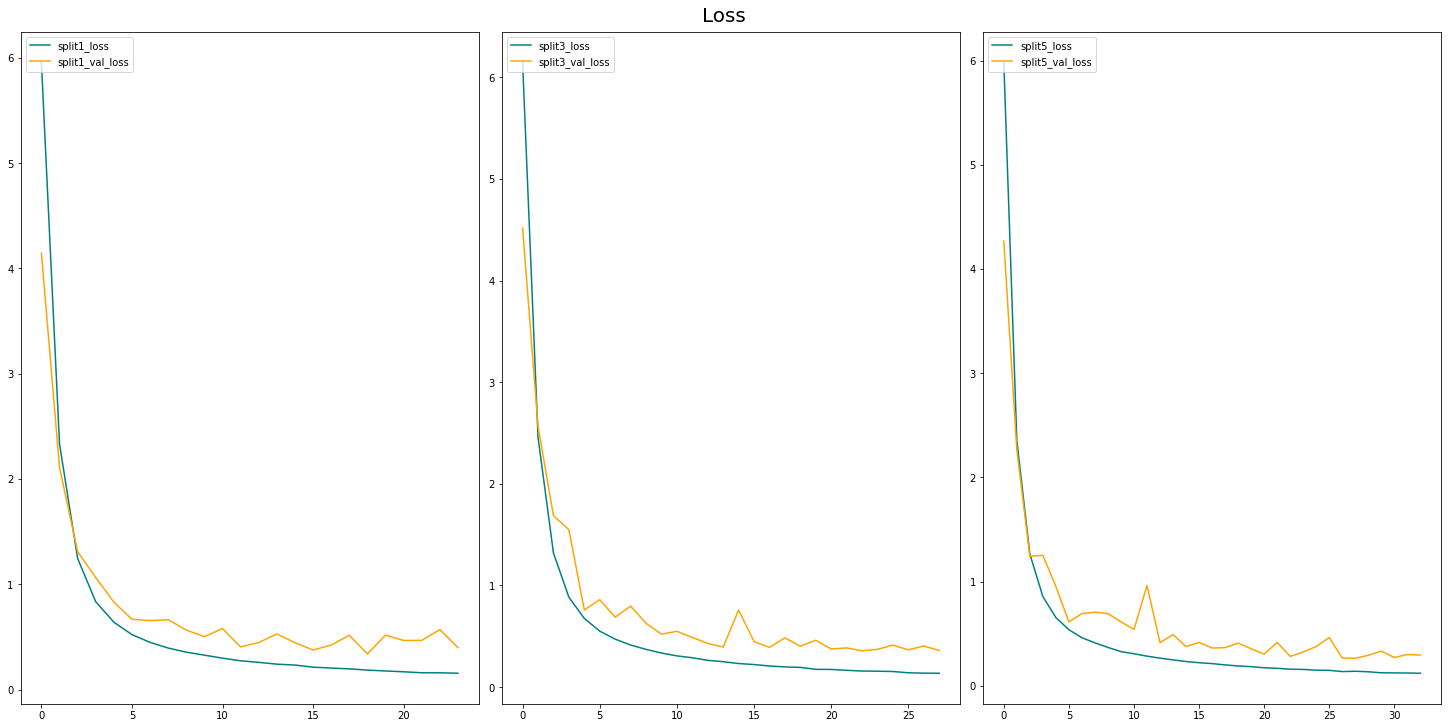

In [110]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['loss'], color='teal', label='split3_loss')
axs[1].plot(results['split_3']['val_loss'], color='orange', label='split3_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[2].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

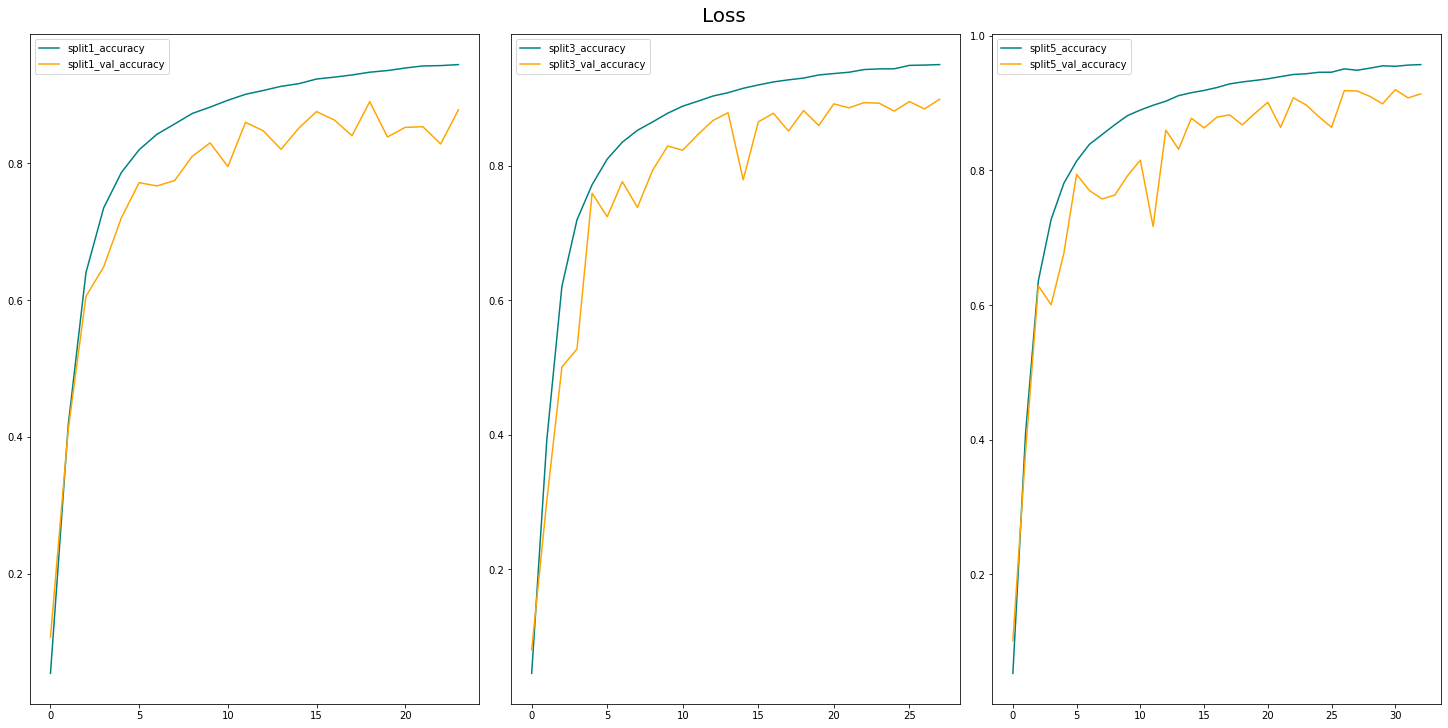

In [111]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['accuracy'], color='teal', label='split3_accuracy')
axs[1].plot(results['split_3']['val_accuracy'], color='orange', label='split3_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[2].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Accuracy', fontsize=20)

plt.show()

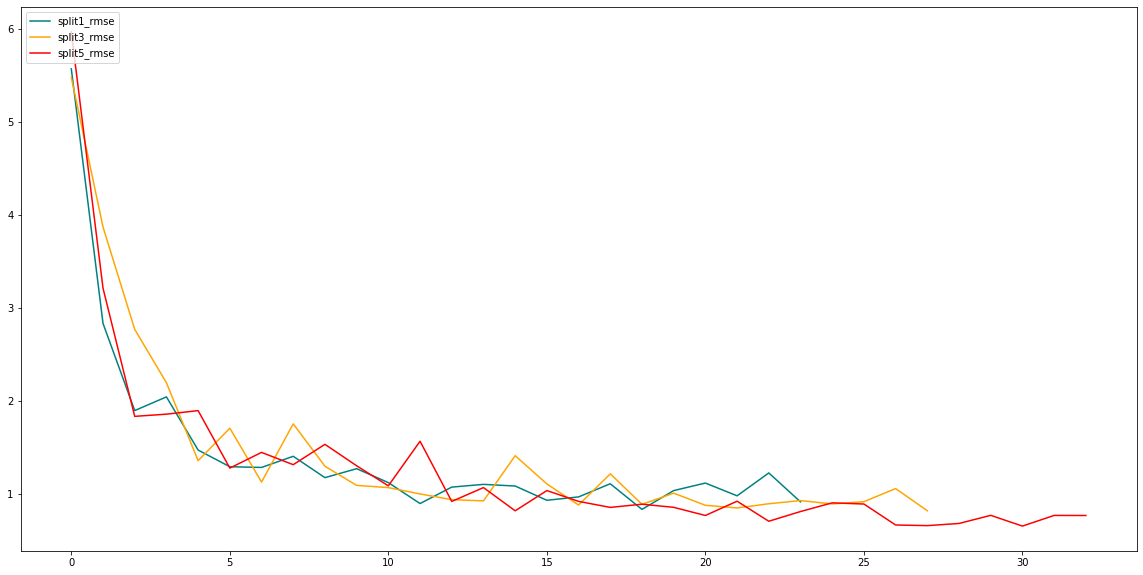

In [112]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_3']['rmse'], color='orange', label='split3_rmse')
plt.plot(results['split_5']['rmse'], color='red', label='split5_rmse')
fig.suptitle('RMSE', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## With tuned hyper paramters,
- Find out time taken for 100 epochs
- Test out model to get RMSE and CDF for distance error